In [1]:
#!pip3 install tf_gnn
#pip install spektral

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import networkx as nx
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import tensorly as tl
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GRU, Reshape, Concatenate, Conv2D, Flatten
from tensorflow.keras.models import Model

In [2]:
print(tf.__version__)

2.7.0


In [3]:
df_route = pd.read_excel('route_data/U101.xlsx',index_col=False)

# DATA PREPARATION HOURLY PATTERN

### Scaled data

In [4]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def scale_data(arr):
    # Reshape the array to a 2D matrix with shape (m*n, p)
    reshaped_arr = arr.reshape((-1, arr.shape[-1]))
    # Create a MinMaxScaler object and apply it to the reshaped array
    scaler = MinMaxScaler()
    scaled_arr = scaler.fit_transform(reshaped_arr)
    # Reshape the scaled array back to the original shape
    scaled_arr = scaled_arr.reshape(arr.shape)
    return scaled_arr

In [5]:
def data_prepare(df_route):
    df_route = df_route[['ETD_DATE','Hour','ORIGIN','DESTINATION']]
    df_route_unique = pd.DataFrame(df_route.value_counts())
    df_route_unique = df_route_unique.reset_index()
    df_route_unique.rename(columns={0:'TRAFFIC FLOW'},inplace=True)
    land_use = pd.read_csv("Land_Use.csv")
    land_use.fillna(0,inplace=True)
    # merged_data_final = pd.merge(df_route_unique, land_use, left_on='ORIGIN', right_on='STOPS')
    # merged_data_final.drop(columns=['STOPS'],inplace=True)



    ten_graph_data = []
    grp_hr = df_route_unique.groupby(['ETD_DATE','Hour'])
    for i, df in grp_hr:
        adj_matrix = np.zeros((51,51))
        for index, row in df.iterrows():
            adj_matrix[int(row['ORIGIN'])][int(row['DESTINATION'])] = adj_matrix[int(row['ORIGIN'])][int(row['DESTINATION'])] + int(row['TRAFFIC FLOW'])
        ten_graph_data.append(tl.tensor(adj_matrix).reshape(51,51))
    tensor_graph_data = tf.convert_to_tensor(ten_graph_data)
    tensor_graph_data = np.array(tensor_graph_data)


    unique_values = pd.unique(df_route_unique[['ORIGIN','DESTINATION']].values.ravel('K'))
    land_use[land_use['STOPS'].isin(unique_values)==False][['COMMERCIAL','PUBLIC_and_SEMI_PUBLIC','INDUSTRIAL','RESIDENTIAL','PARKS','PUBLIC_UTILITIES']] = 0

    pivot_table_for_node_features = np.array(land_use[['COMMERCIAL', 'PUBLIC_and_SEMI_PUBLIC', 'INDUSTRIAL', 'RESIDENTIAL','PARKS', 'PUBLIC_UTILITIES']])
    list_node_features = []
    for i in range(len(tensor_graph_data)):
            list_node_features.append(pivot_table_for_node_features)
    tensor_node_feature = tf.convert_to_tensor(list_node_features)
    tensor_node_feature = np.array(tensor_node_feature)



    ten_target_value = []
    grp_date = df_route_unique.groupby(['ETD_DATE','Hour'])
    for i, df in grp_date:
        adj_matrix_target = np.zeros((51))
        for index, row in df.iterrows():
            adj_matrix_target[int(row['ORIGIN'])] = adj_matrix_target[int(row['ORIGIN'])] + int(row['TRAFFIC FLOW'])
        ten_target_value.append(tl.tensor(adj_matrix_target))
    tensor_target_value = tf.convert_to_tensor(ten_target_value)
    tensor_target_value = np.array(tensor_target_value).reshape(len(tensor_graph_data),51,1)

    tensor_node_feature = scale_data(tensor_node_feature)
    tensor_graph_data = scale_data(tensor_graph_data)


    return tensor_graph_data,tensor_node_feature,tensor_target_value

In [39]:
# df_route = df_route[['ETD_DATE','ORIGIN','DESTINATION']]

In [40]:
# df_route_unique = pd.DataFrame(df_route.value_counts())
# df_route_unique = df_route_unique.reset_index()
# df_route_unique.rename(columns={0:'TRAFFIC FLOW'},inplace=True)
# land_use = pd.read_csv("Land_Use.csv")
# land_use.fillna(0,inplace=True)
# merged_data_final = pd.merge(df_route_unique, land_use, left_on='ORIGIN', right_on='STOPS')
# merged_data_final.drop(columns=['STOPS'],inplace=True)

In [41]:
# merged_data_final.sort_values(by='ETD_DATE')

In [42]:
# Find unique values of the origin and destination columns
# unique_values = pd.unique(merged_data_final[['ORIGIN','DESTINATION']].values.ravel('K'))

# # Create a dictionary to map each unique value to a corresponding integer
# mapping_dict = {value: index for index, value in enumerate(unique_values)}

# # Use the `map` method to replace the origin and destination values with the mapped integer values
# merged_data_final['ORIGIN'] = merged_data_final['ORIGIN'].map(mapping_dict)
# merged_data_final['DESTINATION'] = merged_data_final['DESTINATION'].map(mapping_dict)

In [10]:
# ten_graph_data = []
# grp_hr = merged_data_final.groupby(['Hour'])
# for i, df in grp_hr:
#     adj_matrix = np.zeros((17,17))
#     for index, row in df.iterrows():
#         adj_matrix[int(row['ORIGIN'])][int(row['DESTINATION'])] = 1
#     ten_graph_data.append(tl.tensor(adj_matrix).reshape(17,17))
# tensor_graph_data = tf.convert_to_tensor(ten_graph_data)
# # tensor_graph_data = tf.transpose(tensor_graph_data, perm=[1, 2, 0])
# tensor_graph_data = np.array(tensor_graph_data)
# tensor_graph_data.shape

In [43]:
# ten_graph_data = []
# grp_hr = merged_data_final.groupby(['ETD_DATE'])
# for i, df in grp_hr:
#     adj_matrix = np.zeros((51,51))
#     for index, row in df.iterrows():
#             adj_matrix[int(row['ORIGIN'])][int(row['DESTINATION'])] = adj_matrix[int(row['ORIGIN'])][int(row['DESTINATION'])] + int(row['TRAFFIC FLOW'])
#     ten_graph_data.append(tl.tensor(adj_matrix).reshape(51,51))
# tensor_graph_data = tf.convert_to_tensor(ten_graph_data)
# # tensor_graph_data = tf.transpose(tensor_graph_data, perm=[1, 2, 0])
# tensor_graph_data = np.array(tensor_graph_data)
# tensor_graph_data.shape

In [12]:
# Node features represent information about each node in the graph at each time stamp.Tensor of shape [N,D,F] where F is number of features per node.
# pivot_table_for_node_features = merged_data_final.pivot_table(index='ORIGIN',columns='Hour',values=merged_data_final[['COMMERCIAL', 'PUBLIC_and_SEMI_PUBLIC', 'INDUSTRIAL', 'RESIDENTIAL',
#        'PARKS', 'PUBLIC_UTILITIES']]).fillna(0)
# list_node_features = []
# pv_nf = tl.tensor(pivot_table_for_node_features)
# for i in range(17):
#         list_node_features.append(tl.tensor(pivot_table_for_node_features)[i].reshape(-1,6))
# tensor_node_feature = tf.convert_to_tensor(list_node_features)
# tensor_node_feature = tf.transpose(tensor_node_feature, perm=[1, 0, 2])
# tensor_node_feature = np.array(tensor_node_feature)
# tensor_node_feature.shape

In [44]:
# unique_values = pd.unique(merged_data_final[['ORIGIN','DESTINATION']].values.ravel('K'))
# land_use[land_use['STOPS'].isin(unique_values)==False][['COMMERCIAL','PUBLIC_and_SEMI_PUBLIC','INDUSTRIAL','RESIDENTIAL','PARKS','PUBLIC_UTILITIES']] =0

In [45]:
# Node features represent information about each node in the graph at each time stamp.Tensor of shape [N,D,F] where F is number of features per node.
# bus_stops_land_use = land_use[land_use['STOPS'].isin(unique_values)]
# pivot_table_for_node_features = np.array(land_use[['COMMERCIAL', 'PUBLIC_and_SEMI_PUBLIC', 'INDUSTRIAL', 'RESIDENTIAL','PARKS', 'PUBLIC_UTILITIES']])
# list_node_features = []
# for i in range(183):
#         list_node_features.append(pivot_table_for_node_features)
# tensor_node_feature = tf.convert_to_tensor(list_node_features)
# tensor_node_feature = np.array(tensor_node_feature)
# tensor_node_feature.shape


In [15]:
# Target value 
# pivot_table_for_target_value = merged_data_final.pivot_table(index='ORIGIN',columns='Hour',values='TRAFFIC FLOW').fillna(0)
# list_target_value = tl.tensor(pivot_table_for_target_value).reshape(17,16,1)
# tensor_target_value = tf.convert_to_tensor(list_target_value)
# tensor_target_value = tf.transpose(tensor_target_value, perm=[1, 0, 2])
# tensor_target_value = np.array(tensor_target_value)
# tensor_target_value.shape

In [46]:
# ten_target_value = []
# grp_date = merged_data_final.groupby(['ETD_DATE'])
# for i, df in grp_date:
#     adj_matrix_target = np.zeros((51))
#     for index, row in df.iterrows():
#         adj_matrix_target[int(row['ORIGIN'])] = adj_matrix_target[int(row['ORIGIN'])] + row['TRAFFIC FLOW']
#     ten_target_value.append(tl.tensor(adj_matrix_target))
# tensor_target_value = tf.convert_to_tensor(ten_target_value)
# tensor_target_value = np.array(tensor_target_value).reshape(183,51,1)
# tensor_target_value.shape

In [138]:
# Scale data

# tensor_node_feature = scale_data(tensor_node_feature)
# tensor_graph_data = scale_data(tensor_graph_data)
# tensor_target_value = scale_data(tensor_target_value)

# scaler1 = MinMaxScaler()
# scaler2 = MinMaxScaler()
# scaler3 = MinMaxScaler()

# reshaped_arr = tensor_target_value.reshape((-1, tensor_target_value.shape[-1]))
# scaler3.fit(reshaped_arr)
# scaled_arr_d = scaler3.inverse_transform(scaled_arr)
# scaled_arr_d = tensor_target_value.reshape(tensor_target_value.shape)






In [6]:
tensor_graph_data,tensor_node_feature,tensor_target_value = data_prepare(df_route)

C:\Users\HIMANGSHUB\AppData\Local\Temp\ipykernel_9368\810228460.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  land_use[land_use['STOPS'].isin(unique_values)==False][['COMMERCIAL','PUBLIC_and_SEMI_PUBLIC','INDUSTRIAL','RESIDENTIAL','PARKS','PUBLIC_UTILITIES']] = 0


In [7]:
tensor_graph_data.shape,tensor_node_feature.shape,tensor_target_value.shape

((2688, 51, 51), (2688, 51, 6), (2688, 51, 1))

In [217]:
# num_nodes = 51
# num_features = 6
# num_timesteps = 2688

# random_indices_1 = np.random.choice(2688, size=536, replace=False)
# all_indices = np.arange(2688)
# random_indices_2 = np.random.choice(np.setdiff1d(all_indices, random_indices_1), size=2151, replace=False)


# train_data = {"adj_matrix": tensor_graph_data[random_indices_2,:,:], "node_features": tensor_node_feature[random_indices_2,:,:]}
# train_targets = tensor_target_value[random_indices_2,:,:]
# test_data = {"adj_matrix": tensor_graph_data[random_indices_1,:,:], "node_features": tensor_node_feature[random_indices_1,:,:]}
# test_targets = tensor_target_value[random_indices_1,:,:]

In [8]:
num_nodes = 51
num_features = 6
num_timesteps = 2688
train_data = {"adj_matrix": tensor_graph_data[:2151], "node_features": tensor_node_feature[:2151]}
train_targets = tensor_target_value[1:2152].astype(np.int64)
test_data = {"adj_matrix": tensor_graph_data[2151:2687], "node_features": tensor_node_feature[2151:2687]}
test_targets = tensor_target_value[2152:].astype(np.int64)

Epoch 1/200
68/68 [==============================] - 10s 69ms/step - loss: 3.6445 - val_loss: 2.8214
Epoch 2/200
68/68 [==============================] - 4s 52ms/step - loss: 2.3199 - val_loss: 2.4654
Epoch 3/200
68/68 [==============================] - 3s 49ms/step - loss: 2.2322 - val_loss: 2.6052
Epoch 4/200
68/68 [==============================] - 3s 49ms/step - loss: 2.1956 - val_loss: 2.3331
Epoch 5/200
68/68 [==============================] - 3s 50ms/step - loss: 2.1169 - val_loss: 2.3211
Epoch 6/200
68/68 [==============================] - 3s 50ms/step - loss: 2.1119 - val_loss: 2.2681
Epoch 7/200
68/68 [==============================] - 4s 52ms/step - loss: 2.0686 - val_loss: 2.2823
Epoch 8/200
68/68 [==============================] - 3s 49ms/step - loss: 2.0436 - val_loss: 2.2440
Epoch 9/200
68/68 [==============================] - 4s 55ms/step - loss: 2.0294 - val_loss: 2.1930
Epoch 10/200
68/68 [==============================] - 4s 54ms/step - loss: 1.9432 - val_loss: 2.030

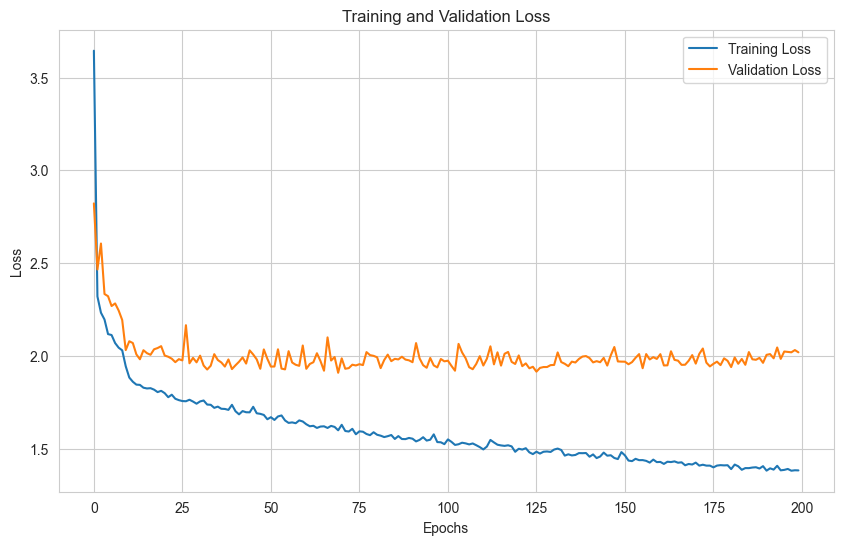

In [16]:
import tensorflow as tf
from spektral.layers import GCNConv
from sklearn.ensemble import BaggingRegressor
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")


class GCN(tf.keras.Model):
    def __init__(self, num_features, num_timesteps,num_nodes):
        super(GCN, self).__init__()

        self.conv1 = GCNConv(128 ,activation="relu")
        self.conv2 = GCNConv(64, activation="relu")
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(128, activation="relu")
        self.dense2 = tf.keras.layers.Dense(64, activation="relu")
        self.dense3 = tf.keras.layers.Dense(num_nodes)

        self.adj_shape = (num_timesteps, None, None)
        self.features_shape = (num_timesteps, None, num_features)

    def call(self, inputs):
        x, a = inputs["node_features"], inputs["adj_matrix"]
        a = tf.transpose(a, perm=[0, 2, 1])
        a = tf.linalg.matmul(a, tf.transpose(a, perm=[0, 2, 1]))
        x = self.conv1([x, a])
        x = self.conv2([x, a])
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)

        return x



# class GCN(tf.keras.Model):
#     def __init__(self, num_features, num_timesteps, num_nodes, dropout_rate=0.2):
#         super(GCN, self).__init__()

#         self.conv1 = GCNConv(256, activation="relu")
#         self.conv2 = GCNConv(128, activation="relu")
#         self.conv3 = GCNConv(64, activation="relu")
#         self.flatten = tf.keras.layers.Flatten()
#         self.dense1 = tf.keras.layers.Dense(32, activation="relu")
#         self.dense2 = tf.keras.layers.Dense(num_nodes*1, activation="linear")

#         self.dropout = tf.keras.layers.Dropout(dropout_rate)
#         self.adj_shape = (num_timesteps, None, None)
#         self.features_shape = (num_timesteps, None, num_features)

#     def call(self, inputs):
#         x, a = inputs["node_features"], inputs["adj_matrix"]
#         a = tf.transpose(a, perm=[0, 2, 1])
#         a = tf.linalg.matmul(a, tf.transpose(a, perm=[0, 2, 1]))
#         x = self.conv1([x, a])
#         x = self.dropout(x)
#         x = self.conv2([x, a])
#         x = self.dropout(x)
#         x = self.conv3([x, a])
#         x = self.dropout(x)
#         x = self.flatten(x)
#         x = self.dense1(x)
#         x = self.dropout(x)
#         x = self.dense2(x)

#         return x



# import tensorflow as tf
# from spektral.layers import GCNConv
# from sklearn.ensemble import BaggingRegressor

# class GCN(tf.keras.Model):
#     def __init__(self, num_features, num_timesteps, num_nodes, dropout_rate=0.1):
#         super(GCN, self).__init__()

#         self.conv1 = GCNConv(256, activation="relu")
#         self.conv2 = GCNConv(128, activation="relu")
#         self.conv3 = GCNConv(64, activation="relu")
#         self.flatten = tf.keras.layers.Flatten()
#         self.dense1 = tf.keras.layers.Dense(64, activation="relu")
#         self.dense2 = tf.keras.layers.Dense(32, activation="relu")
#         self.dense3 = tf.keras.layers.Dense(num_nodes*1)

#         self.dropout = tf.keras.layers.Dropout(dropout_rate)
#         self.adj_shape = (num_timesteps, None, None)
#         self.features_shape = (num_timesteps, None, num_features)

#     def call(self, inputs):
#         x, a = inputs["node_features"], inputs["adj_matrix"]
#         a = tf.transpose(a, perm=[0, 2, 1])
#         a = tf.linalg.matmul(a, tf.transpose(a, perm=[0, 2, 1]))
#         x = self.conv1([x, a])
#         x = self.dropout(x)
#         x = self.conv2([x, a])
#         x = self.dropout(x)
#         x = self.conv3([x, a])
#         x = self.dropout(x)
#         x = self.flatten(x)
#         x = self.dense1(x)
#         x = self.dropout(x)
#         x = self.dense2(x)
#         x = self.dropout(x)
#         x = self.dense3(x)
#         return x

model = GCN(num_features=num_features, num_timesteps=num_timesteps,num_nodes=num_nodes)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss="mae" )
history = model.fit(train_data, train_targets, epochs=200, batch_size=32, validation_data=(test_data, test_targets))

# Get training and validation loss from the history object
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

# Create a list of epoch numbers
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(10, 6))
sns.lineplot(train_loss, label="Training Loss")
sns.lineplot(val_loss, label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [18]:
model.evaluate(train_data, train_targets, verbose=0)

1.3730345964431763

In [19]:
predictions = model.predict(train_data).astype(np.int64)
train_targets = train_targets.reshape(2151,51).astype(np.int64)

In [28]:
from sklearn.metrics import mean_absolute_percentage_error , mean_absolute_error , mean_squared_error
import math
print("MAPE : " ,mean_absolute_percentage_error(train_targets[0:10],predictions[0:10]))
print("MAE : " ,mean_absolute_error(train_targets,predictions))
print("MSE : " ,mean_squared_error(train_targets,predictions))
print("RMSE : ", math.sqrt(mean_squared_error(train_targets,predictions)))

MAPE :  0.09568945743483816
MAE :  1.348374217190363
MSE :  19.372147929371657
RMSE :  4.401380230038261


- pickle.dump(model, open('saved/model.p', 'wb'))


# DATA PREPARATION FOR TESTING

In [163]:
def data_prepare(df_route):
    df_route = df_route[['ETD_DATE','Hour','ORIGIN','DESTINATION']]
    df_route_unique = pd.DataFrame(df_route.value_counts())
    df_route_unique = df_route_unique.reset_index()
    df_route_unique.rename(columns={0:'TRAFFIC FLOW'},inplace=True)
    land_use = pd.read_csv("Land_Use.csv")
    land_use.fillna(0,inplace=True)
    # merged_data_final = pd.merge(df_route_unique, land_use, left_on='ORIGIN', right_on='STOPS')
    # merged_data_final.drop(columns=['STOPS'],inplace=True)



    ten_graph_data = []
    grp_hr = df_route_unique.groupby(['ETD_DATE','Hour'])
    for i, df in grp_hr:
        adj_matrix = np.zeros((51,51))
        for index, row in df.iterrows():
            adj_matrix[int(row['ORIGIN'])][int(row['DESTINATION'])] = adj_matrix[int(row['ORIGIN'])][int(row['DESTINATION'])] + int(row['TRAFFIC FLOW'])
        ten_graph_data.append(tl.tensor(adj_matrix).reshape(51,51))
    tensor_graph_data = tf.convert_to_tensor(ten_graph_data)
    tensor_graph_data = np.array(tensor_graph_data)


    # unique_values = pd.unique(merged_data_final[['ORIGIN','DESTINATION']].values.ravel('K'))
    # land_use[land_use['STOPS'].isin(unique_values)==False][['COMMERCIAL','PUBLIC_and_SEMI_PUBLIC','INDUSTRIAL','RESIDENTIAL','PARKS','PUBLIC_UTILITIES']] = 0

    pivot_table_for_node_features = np.array(land_use[['COMMERCIAL', 'PUBLIC_and_SEMI_PUBLIC', 'INDUSTRIAL', 'RESIDENTIAL','PARKS', 'PUBLIC_UTILITIES']])
    list_node_features = []
    for i in range(len(tensor_graph_data)):
            list_node_features.append(pivot_table_for_node_features)
    tensor_node_feature = tf.convert_to_tensor(list_node_features)
    tensor_node_feature = np.array(tensor_node_feature)



    ten_target_value = []
    grp_date = df_route_unique.groupby(['ETD_DATE','Hour'])
    for i, df in grp_date:
        adj_matrix_target = np.zeros((51))
        for index, row in df.iterrows():
            adj_matrix_target[int(row['ORIGIN'])] = adj_matrix_target[int(row['ORIGIN'])] + row['TRAFFIC FLOW']
        ten_target_value.append(tl.tensor(adj_matrix_target))
    tensor_target_value = tf.convert_to_tensor(ten_target_value)
    tensor_target_value = np.array(tensor_target_value).reshape(len(tensor_graph_data),51,1)

    tensor_node_feature = scale_data(tensor_node_feature)
    tensor_graph_data = scale_data(tensor_graph_data)


    return tensor_graph_data,tensor_node_feature,tensor_target_value

# TESTING WITH NEW DATASET

In [20]:
U102 = pd.read_excel('route_data/U106.xlsx',index_col=False)

In [21]:
tensor_graph_data_1,tensor_node_feature_1,tensor_target_value_1 = data_prepare(U102)

C:\Users\HIMANGSHUB\AppData\Local\Temp\ipykernel_12980\3745735706.py:15: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, df in grp_hr:
C:\Users\HIMANGSHUB\AppData\Local\Temp\ipykernel_12980\3745735706.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  land_use[land_use['STOPS'].isin(unique_values)==False][['COMMERCIAL','PUBLIC_and_SEMI_PUBLIC','INDUSTRIAL','RESIDENTIAL','PARKS','PUBLIC_UTILITIES']] = 0
C:\Users\HIMANGSHUB\AppData\Local\Temp\ipykernel_12980\3745735706.py:38: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating 

In [22]:
test_data_102 = {"adj_matrix": tensor_graph_data_1[1:182], "node_features": tensor_node_feature_1[1:182]}
test_targets_102 = tensor_target_value_1[2:183].reshape(-1,51).astype(np.int64)

predictions = model.predict(test_data_102).astype(np.int64)
mapeTensor = tf.keras.losses.mae(test_targets_102,predictions)
np.mean(mapeTensor.numpy())

11.67403314917127

# MODEL WITH TIMESTAMP

In [539]:
window_size = 7

# Create input/output pairs
X = []
y = []
for i in range(len(tensor_graph_data) - window_size):
    X.append(tensor_graph_data[i:i+window_size])
    y.append(tensor_graph_data[i+window_size])


# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

In [542]:
y.shape

(176, 17, 17)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout ,Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanSquaredError
from spektral.layers import GCNConv

# Define the input shape
input_shape = (7, 17, 17)

# Define the model inputs
x_in = Input(shape=input_shape)
x = Lambda(lambda x: x[..., tf.newaxis])(x_in)  # Add an extra dimension
# Build the GCNConv model
x = GCNConv(32, activation="relu")([x_in])
x = GCNConv(64, activation="relu")([x])
x = GCNConv(128, activation="relu")([x])
x = Dropout(0.5)(x)
x = GCNConv(17, activation="linear")([x])

# Define the model outputs
x_out = x

# Build the model
model = Model(inputs=x_in, outputs=x_out)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=MeanSquaredError(),
    metrics=[MeanSquaredError()],
)

# Print the model summary
model.summary()

    
# model = TGCN(num_timesteps=7, num_nodes=17)
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mae")

# history = model.fit(X, y, epochs=400, batch_size=32, validation_split=0.2)

In [28]:
# pip install keras-tuner --quiet

In [27]:
# from tensorflow.keras import layers
# from tensorflow.keras.layers import Dense
# from keras_tuner.tuners import RandomSearch

In [40]:
# def build_model(hp):
#     model = keras.Sequential()
#     for i in range(hp.Int('num_layers', 2, 20)):
#         model.add(GCNConv(128, activation="relu"))
#         model.add(GCNConv(64, activation="relu"))
#         model.add(GCNConv(32,activation="relu"))
#         model.add(layers.Flatten())
#         model.add(layers.Dense(units=hp.Int('units_' + str(i),
#                                                 min_value=24,
#                                                 max_value=512,
#                                                 step=32),
#                                 activation='relu'))
#         model.add(layers.Dense(units=hp.Int('units_' + str(i),
#                                                 min_value=24,
#                                                 max_value=512,
#                                                 step=32),
#                                 activation='relu'))
#         model.add(layers.Dense(num_nodes*1))



#     model.compile(
#         optimizer=keras.optimizers.Adam(
#             hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
#         loss= hp.Choice('loss' , ['mean_absolute_error','mean_squared_error']),
#     metrics= hp.Choice('metrics' , ['mean_absolute_error','mean_squared_error']))
#     return model

In [292]:
# tuner  = RandomSearch(
#     build_model,
#     objective=['val_mean_absolute_error','val_mean_squared_error'],
#     max_trials=5,
#     executions_per_trial=3,
#     directory='Hyperparameter_tuning',
#     project_name='Insurance estimator'
# )

## DEMO MODEL 

In [ ]:
# import tensorflow as tf
# from spektral.layers import GCNConv
# from sklearn.ensemble import BaggingRegressor


# num_nodes = 17
# num_features = 6
# num_timesteps = 16

# adj_matrix_data = np.random.randn(num_timesteps,num_nodes, num_nodes)
# node_features_data = np.random.randn(num_timesteps,num_nodes, num_features)
# target_data = np.random.randn(num_timesteps,num_nodes, 1)

# print(adj_matrix_data.shape ,  node_features_data.shape , target_data.shape)

# # Split the data into training and testing sets
# train_data = {"adj_matrix": adj_matrix_data[:10], "node_features": node_features_data[:10]}
# train_targets = target_data[:10]
# test_data = {"adj_matrix": adj_matrix_data[10:], "node_features": node_features_data[10:]}
# test_targets = target_data[10:]



# class GCN(tf.keras.Model):
#     def __init__(self, num_features, num_timesteps, dropout_rate=0.2):
#         super(GCN, self).__init__()

#         self.conv1 = GCNConv(64, activation="relu")
#         self.conv2 = GCNConv(32, activation="relu")
#         self.flatten = tf.keras.layers.Flatten()
#         self.dense1 = tf.keras.layers.Dense(16, activation="relu")
#         self.dense2 = tf.keras.layers.Dense(num_nodes*1)

#         self.dropout = tf.keras.layers.Dropout(dropout_rate)
#         self.adj_shape = (num_timesteps, None, None)
#         self.features_shape = (num_timesteps, None, num_features)

#     def call(self, inputs):
#         x, a = inputs["node_features"], inputs["adj_matrix"]
#         a = tf.transpose(a, perm=[0, 2, 1])
#         a = tf.linalg.matmul(a, tf.transpose(a, perm=[0, 2, 1]))
#         x = self.conv1([x, a])
#         x = self.dropout(x)
#         x = self.conv2([x, a])
#         x = self.dropout(x)
#         x = self.flatten(x)
#         x = self.dense1(x)
#         x = self.dropout(x)
#         x = self.dense2(x)

#         return x
    
# model = GCN(num_features=num_features, num_timesteps=num_timesteps)
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mse" )
# model.fit(train_data, train_targets, epochs=700, validation_data=(test_data, test_targets))
# pre = model.predict(test_data)

In [ ]:
#==============================================================================================================

In [ ]:
# num_nodes = 17
# num_features = 6
# num_timesteps = 16

# adj_matrix_data = np.random.randn(num_nodes, num_nodes, num_timesteps)
# node_features_data = np.random.randn(num_nodes, num_timesteps, num_features)
# target_data = np.random.randn(num_nodes, num_timesteps, 1)

# train_data = {"adj_matrix": adj_matrix_data[:2], "node_features": node_features_data[:2]}
# train_targets = target_data[:2]
# test_data = {"adj_matrix": adj_matrix_data[2:], "node_features": node_features_data[2:]}
# test_targets = target_data[2:]








In [ ]:
# import tensorflow as tf
# from tensorflow.keras.layers import Input, Dense, GRU, Reshape, Concatenate, Conv2D, Flatten
# from tensorflow.keras.models import Model

# # Define the input shapes for the adjacency matrix and node features tensors
# num_nodes = 17
# num_features = 6
# num_timesteps = 16

# adj_matrix = Input(shape=(num_nodes, num_nodes, num_timesteps), name="adj_matrix")
# node_features = Input(shape=(num_nodes, num_timesteps, num_features), name="node_features")

# # Define the T-GCN layers that will process the input data
# num_filters = 32
# kernel_size = (1, 2)




# # Generate example data for training and testing
# import numpy as np

# adj_matrix_data = np.random.randn(num_nodes, num_nodes, num_timesteps)
# node_features_data = np.random.randn(num_nodes, num_timesteps, num_features)
# target_data = np.random.randn(num_nodes, num_timesteps, 1)

# # Split the data into training and testing sets
# train_data = {"adj_matrix": adj_matrix_data[:2], "node_features": node_features_data[:2]}
# train_targets = target_data[:2]
# test_data = {"adj_matrix": adj_matrix_data[2:], "node_features": node_features_data[2:]}
# test_targets = target_data[2:]



In [ ]:
# import tensorflow as tf
# from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Concatenate, Dense, Reshape, Dropout
# from tensorflow.keras.models import Model
# import numpy as np

# # Define model hyperparameters
# num_filters = 16
# num_timesteps = 16
# num_nodes = 17
# num_features = 6


# adj_matrix_data = np.random.randn(num_nodes, num_nodes, num_timesteps)
# node_features_data = np.random.randn(num_nodes, num_timesteps, num_features)
# target_data = np.random.randn(num_nodes, num_timesteps, 1)


# # Define input layers
# adj_matrix_input = Input(shape=(num_nodes, num_nodes, num_timesteps), name='adj_matrix_input')
# node_features_input = Input(shape=(num_nodes, num_timesteps, num_features), name='node_features_input')





# # Define temporal convolutional layer
# def temporal_conv_layer(x, adj_matrix, num_filters, kernel_size):
#     # Add channel dimension to adjacency matrix
#     adj_matrix = tf.expand_dims(adj_matrix, axis=-1)
#     # Perform convolution on adjacency matrix
#     adj_matrix = Conv2D(filters=num_filters, kernel_size=(1, kernel_size))(adj_matrix)
#     adj_matrix = BatchNormalization()(adj_matrix)
#     adj_matrix = Activation('relu')(adj_matrix)
#     # Remove channel dimension from adjacency matrix
#     adj_matrix = tf.squeeze(adj_matrix, axis=-1)
#     # Perform multiplication between node features and adjacency matrix
#     x = tf.linalg.matmul(adj_matrix, x) 
#     return x


# # Define T-GCN model
# x = node_features_input
# for i in range(2):
#     x = temporal_conv_layer(x, adj_matrix_input, num_filters, 2)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     x = Dropout(0.5)(x)
# x = tf.reduce_mean(x, axis=1)
# x = Dense(64, activation='relu')(x)
# x = Dropout(0.5)(x)
# output = Dense(1)(x)

# # Define model inputs and outputs
# inputs = [adj_matrix_input, node_features_input]
# model = Model(inputs=inputs, outputs=output)

# # Compile the model
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')






# # Split the data into training and testing sets
# train_data = {"adj_matrix": adj_matrix_data[:2], "node_features": node_features_data[:2]}
# train_targets = target_data[:2]
# test_data = {"adj_matrix": adj_matrix_data[2:], "node_features": node_features_data[2:]}
# test_targets = target_data[2:]



# # Train the model
# model.fit(train_data, train_targets, validation_data=(test_data, test_targets), epochs=10, batch_size=2)

# # Evaluate the model on the testing set
# test_loss = model.evaluate(test_data, test_targets)
# print("Test loss:", test_loss)


In [ ]:
# import tensorflow as tf
# import tensorflow_addons as tfa

# class TGCN(tf.keras.Model):
#     def __init__(self, num_nodes, num_features, num_timesteps, hidden_units, dropout_rate):
#         super(TGCN, self).__init__()
        
#         # Graph convolutional layers
#         self.gcn1 = tfa.layers.GraphConvolution(units=hidden_units, activation="relu")
#         self.gcn2 = tfa.layers.GraphConvolution(units=hidden_units, activation="relu")
        
#         # Temporal convolutional layers
#         self.tcn1 = tf.keras.layers.Conv1D(filters=hidden_units, kernel_size=3, activation="relu", padding="same")
#         self.tcn2 = tf.keras.layers.Conv1D(filters=hidden_units, kernel_size=3, activation="relu", padding="same")
        
#         # Output layer
#         self.dense = tf.keras.layers.Dense(units=1, activation=None)
        
#         # Dropout layer
#         self.dropout = tf.keras.layers.Dropout(rate=dropout_rate)
        
#         # Reshape node features to 3D tensor
#         self.reshape = tf.keras.layers.Reshape(target_shape=(num_timesteps, num_nodes, num_features))
        
#         # Transpose node features from (batch_size, num_timesteps, num_nodes, num_features) to 
#         # (batch_size, num_nodes, num_timesteps, num_features) to match adjacency matrix shape
#         self.transpose = tf.keras.layers.Permute(dims=(1, 2, 0, 3))
    
#     def call(self, inputs, training=False):
#         # Unpack input dictionary
#         adj_matrix = inputs["adj_matrix"]
#         node_features = inputs["node_features"]
        
#         # Reshape node features to 3D tensor
#         node_features = self.reshape(node_features)
        
#         # Transpose node features to match adjacency matrix shape
#         node_features = self.transpose(node_features)
        
#         # Apply graph convolutional layers
#         h = self.gcn1([node_features, adj_matrix])
#         h = self.dropout(h, training=training)
#         h = self.gcn2([h, adj_matrix])
#         h = self.dropout(h, training=training)
        
#         # Apply temporal convolutional layers
#         h = self.tcn1(h)
#         h = self.dropout(h, training=training)
#         h = self.tcn2(h)
#         h = self.dropout(h, training=training)
        
#         # Reshape output tensor to 2D tensor
#         h = tf.keras.layers.Flatten()(h)
        
#         # Apply output layer
#         outputs = self.dense(h)
        
#         return outputs

# from tensorflow.keras.layers import Input, Dense, Dropout
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.regularizers import l2

# class GCN:
#     def __init__(self, filters, output_dim, activation, dropout):
#         self.filters = filters
#         self.output_dim = output_dim
#         self.activation = activation
#         self.dropout = dropout
    
#     def __call__(self, inputs):
#         x, a = inputs
        
#         # Graph convolutional layer
#         h = Dense(self.filters, activation=self.activation)(x)
#         h = Dropout(self.dropout)(h)
#         h = Dense(self.output_dim, activation=None)(h)
        
#         # Graph pooling layer
#         pooled = Lambda(lambda x: tf.matmul(a, x))(h)
        
#         return self.activation(pooled)


In [ ]:
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.layers import Input, Dense, Dropout
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adam
# from tcn import TCN

# # Data dimensions
# num_nodes = 17
# num_features = 6
# num_timesteps = 16

# # Data
# adj_matrix_data = np.random.randn(num_nodes, num_nodes, num_timesteps)
# node_features_data = np.random.randn(num_nodes, num_timesteps, num_features)
# target_data = np.random.randn(num_nodes, num_timesteps, 1)

# train_data = {"adj_matrix": adj_matrix_data[:2], "node_features": node_features_data[:2]}
# train_targets = target_data[:2]
# test_data = {"adj_matrix": adj_matrix_data[2:], "node_features": node_features_data[2:]}
# test_targets = target_data[2:]

# # Model
# num_filters = 16
# kernel_size = 3
# dropout_rate = 0.2

# def get_model():
#     inputs = []
#     outputs = []
#     for i in range(num_timesteps):
#         adj_matrix_input = Input(shape=(num_nodes, num_nodes), name=f"adj_matrix_{i}")
#         node_features_input = Input(shape=(num_nodes, num_features), name=f"node_features_{i}")
#         gcn = tf.keras.layers.GCNConv(
#             filters=num_filters,
#             kernel_size=kernel_size,
#             activation='relu'
#         )(node_features_input, adj_matrix_input)
#         gcn = Dropout(dropout_rate)(gcn)
#         tcn = TCN(
#             nb_filters=num_filters,
#             kernel_size=kernel_size,
#             dilations=[1, 2, 4, 8],
#             dropout_rate=dropout_rate,
#             use_skip_connections=True,
#             activation='relu'
#         )(gcn)
#         tcn = Dropout(dropout_rate)(tcn)
#         output = Dense(1, activation='linear')(tcn)
#         inputs += [adj_matrix_input, node_features_input]
#         outputs += [output]

#     model = Model(inputs=inputs, outputs=outputs)
#     model.compile(loss='mse', optimizer=Adam(lr=0.001))
#     return model

# model = get_model()
# model.summary()

# # Training
# history = model.fit(
#     x=[train_data["adj_matrix"], train_data["node_features"]],
#     y=train_targets,
#     epochs=10,
#     batch_size=2,
#     validation_data=([test_data["adj_matrix"], test_data["node_features"]], test_targets)
# )


In [ ]:
# import tensorflow as tf

# num_nodes = 17
# num_features = 6
# num_timesteps = 16

# # Define the T-GCN model architecture
# class TGCN(tf.keras.Model):
#     def _init_(self, num_nodes, num_features):
#         super(TGCN, self)._init_()
#         self.conv1 = tf.keras.layers.Convolutional1D(filters=32, kernel_size=2, activation='relu')
#         self.conv2 = tf.keras.layers.Convolutional1D(filters=16, kernel_size=2, activation='relu')
#         self.pool = tf.keras.layers.GlobalMaxPooling1D()
#         self.dense1 = tf.keras.layers.Dense(units=64, activation='relu')
#         self.dense2 = tf.keras.layers.Dense(units=1)

#     def call(self, inputs):
#         # Extract the adjacency matrix and node features from the input dictionary
#         adj_matrix = inputs['adj_matrix']
#         node_features = inputs['node_features']

#         # Apply graph convolutional layers
#         x = tf.transpose(node_features, perm=[0, 2, 1])
#         for i in range(adj_matrix.shape[2]):
#             x = tf.matmul(adj_matrix[:, :, i], x)
#             x = self.conv1(x)
#             x = self.conv2(x)
#             x = self.pool(x)

#         # Apply dense layers
#         x = self.dense1(x)
#         x = self.dense2(x)

#         return x

# # Create an instance of the TGCN model
# model = TGCN(num_nodes, num_features)

# # Compile the model
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

# # # Train the model
# # model.fit(train_data, train_targets, epochs=10, batch_size=2)

# # # Evaluate the model on the test data
# # loss = model.evaluate(test_data, test_targets)
# # print('Test loss:', loss)

In [ ]:
# import tensorflow as tf
# from spektral.layers import GCNConv
# from tensorflow.keras import layers

# # Define the GCN model architecture
# class GCN(tf.keras.Model):
#     def __init__(self, num_nodes, num_features, num_filters):
#         super(GCN, self).__init__()

#         # Define the graph convolutional layer
#         self.gcn_layer = GCNConv(num_filters, activation='relu')

#         # Define the output layer
#         self.output_layer = layers.Dense(1, activation=None)

#     def call(self, inputs):
#         # Extract the input data
#         adj_matrix = inputs['adj_matrix']
#         node_features = inputs['node_features']

#         # Apply the graph convolutional layer
#         x = self.gcn_layer([node_features, adj_matrix])

#         # Compute the output
#         output = self.output_layer(x)
#         return output

# # Define the model hyperparameters
# num_nodes = 17
# num_features = 6
# num_filters = 16

# # Create an instance of the GCN model
# model = GCN(num_nodes, num_features, num_filters)

# # Compile the model
# model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse', metrics=['mae'])





# # Generate some sample data
# adj_matrix_data = np.random.randn(num_nodes, num_timesteps, num_nodes)
# node_features_data = np.random.randn(num_nodes, num_timesteps, num_features)
# target_data = np.random.randn(num_nodes, num_timesteps, 1)

# # Split the data into training and validation sets
# train_data = {"adj_matrix": adj_matrix_data[2:], "node_features": node_features_data[2:]}
# train_targets = target_data[2:]  # Keep only the first 15 timesteps
# test_data = {"adj_matrix": adj_matrix_data[:2], "node_features": node_features_data[:2]}
# test_targets = target_data[:2]  # Keep only the first 15 timesteps






# # Train the model
# model.fit(train_data, train_targets, epochs=10, validation_data=(test_data, test_targets))


In [ ]:
#===========================================================================================================================

In [ ]:
# import tensorflow as tf
# from spektral.layers import GCNConv

# class GCN(tf.keras.Model):
#     def __init__(self, num_features, num_timesteps):
#         super(GCN, self).__init__()

#         self.conv1 = GCNConv(64, activation="relu")
#         self.conv2 = GCNConv(32, activation="relu")
#         self.flatten = tf.keras.layers.Flatten()
#         self.dense1 = tf.keras.layers.Dense(16, activation="relu")
#         self.dense2 = tf.keras.layers.Dense(1)

#         self.adj_shape = (num_timesteps, None, None)
#         self.features_shape = (num_timesteps, None, num_features)

#     def call(self, inputs):
#         x, a = inputs["node_features"], inputs["adj_matrix"]
#         a = tf.transpose(a, perm=[0, 2, 1])
#         a = tf.linalg.matmul(a, tf.transpose(a, perm=[0, 2, 1]))
#         x = self.conv1([x, a])
#         x = self.conv2([x, a])
#         x = self.flatten(x)
#         x = self.dense1(x)
#         x = self.dense2(x)

#         return x


In [ ]:
# num_nodes = 17
# num_features = 6
# num_timesteps = 16

# adj_matrix_data = np.random.randn(num_nodes, num_nodes, num_timesteps)
# node_features_data = np.random.randn(num_nodes, num_timesteps, num_features)
# target_data = np.random.randn(num_nodes, num_timesteps, 1)

# train_data = {"adj_matrix": adj_matrix_data[:2], "node_features": node_features_data[:2]}
# train_targets = target_data[:2]
# test_data = {"adj_matrix": adj_matrix_data[2:], "node_features": node_features_data[2:]}
# test_targets = target_data[2:]

In [ ]:
# model = GCN(num_features=num_features, num_timesteps=num_timesteps)
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mse")
# model.fit(train_data, train_targets, epochs=100, validation_data=(test_data, test_targets))

In [ ]:
# #Data
# adj_matrix_data = np.random.randn(num_nodes, num_nodes, num_timesteps)
# node_features_data = np.random.randn(num_nodes, num_timesteps, num_features)
# target_data = np.random.randn(num_nodes, num_timesteps, 1)

# # Split the data into training and testing sets
# train_data = {"adj_matrix": adj_matrix_data[:2], "node_features": node_features_data[:2]}
# train_targets = target_data[:2]
# test_data = {"adj_matrix": adj_matrix_data[2:], "node_features": node_features_data[2:]}
# test_targets = target_data[2:]
